# Get started with circuit cutting using gate cuts

This guide demonstrates two working examples of using gate cuts to get started working with the `qiskit-addon-cutting` package. It will cover using gate cutting to reduce the circuit width (the number of qubits) and circuit depth (the number of circuit instructions). We will cut gates to enable the reconstruction of a four-qubit circuit using two two-qubit subexperiments.

The first example will use the [`EfficentSU2`](../api/qiskit/qiskit.circuit.library.EfficientSU2) ansatz and reconstructs the following observable:

Observable: SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'XIXI', 'ZIZZ', 'IXIX'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j])


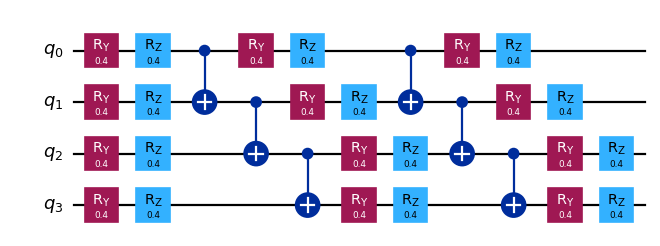

In [9]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import SamplerV2, Batch
from qiskit_aer.primitives import EstimatorV2
from qiskit_addon_cutting import (
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)

qc = EfficientSU2(4, entanglement="linear", reps=2).decompose()
qc.assign_parameters([0.4] * len(qc.parameters), inplace=True)


observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])
print(f"Observable: {observable}")

qc.draw("mpl", scale=0.8)

## Gate cutting to reduce circuit width

We will start by partitioning the circuit and observable into *subcircuits* and *subobservables* using the [`partition_problem`](../api/qiskit-addon-cutting/qiskit-addon-cutting#partition_problem) method. This function will ingest a partitioning scheme according to a label string of the form `"AABB"` where each label in this string corresponds to the `circuit` qubit in the same index. Qubits sharing a common partition label will be grouped together, and any non-local gates which span more than one partition will be cut.

<Admonition type="information" title="Note">
   The observables kwarg to partition_problem is of type PauliList. Observable term coefficients and phases are ignored during decomposition of the problem and execution of the subexperiments. They may be re-applied during reconstruction of the expectation value.
</Admonition>

Sampling overhead: 81.0
Subobservables: {'A': PauliList(['II', 'ZI', 'ZZ', 'XI', 'ZZ', 'IX']), 'B': PauliList(['ZZ', 'IZ', 'II', 'XI', 'ZI', 'IX'])}


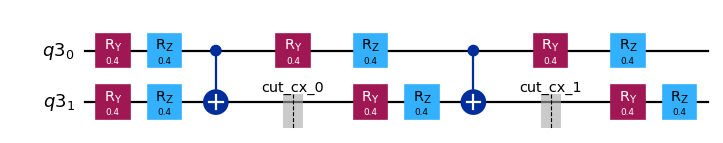

In [10]:
partitioned_problem = partition_problem(
    circuit=qc, partition_labels="AABB", observables=observable.paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases


print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")
print(f"Subobservables: {subobservables}")
subcircuits["A"].draw("mpl", scale=0.8)

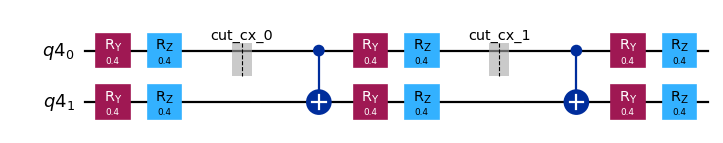

In [11]:
subcircuits["B"].draw("mpl", scale=0.8)

The next step is then to generate the *subexperiments* to be executed on a QPU. This is done through the [`generate_cutting_experiments`](../api/qiskit-addon-cutting/qiskit-addon-cutting#generate_cutting_experiments) which accepts circuit and observable arguments as dictionaries mapping the qubit partition label to the respective *subcircuit* and *subobservable*.

To estimate the expectation value of the full-sized circuit, many subexperiments are generated from the decomposed gates' joint quasiprobability distribution and then executed on one or more QPUs. The number of samples to be taken from this distribution is controlled by the `num_samples` argument.

The following code block generates the subexperiments and executes them using the `Sampler` primitive on a local simulator. (To run these on a QPU, change the `backend` to your chosen QPU resource.)

In [12]:
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)

# Set a backend to use and transpile the subexperiments
backend = FakeManilaV2()
pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}

# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }

# Retrieve results
results = {label: job.result() for label, job in jobs.items()}

Lastly the expectation value of the full circuit can be reconstructed using the [`reconstruct_expectation_values`](../api/qiskit-addon-cutting/qiskit-addon-cutting#reconstruct_expectation_values) method.

The code block below reconstructs the results and compares them with the exact expectation value.

In [13]:
# Get expectation values for each observable term
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)

# Reconstruct final expectation value
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)


estimator = EstimatorV2()
exact_expval = estimator.run([(qc, observable)]).result()[0].data.evs
print(
    f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}"
)
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(
    f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}"
)
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 0.59146589
Exact expectation value: 0.56254612
Error in estimation: 0.02891977
Relative error in estimation: 0.0514087


## Gate cutting to reduce circuit depth

Next we'll demonstrate a workflow which reduces a circuit's depth by cutting distant gates, avoiding a large series of swap gates that would otherwise be introduced.

We'll start first with the [`EfficientSU2`](../api/qiskit/qiskit.circuit.library.EfficientSU2) ansatz, but with "circular" entanglement in order to introduce distant gates. We'll also define the same observable to measure as the previous example.

Observable: SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'XIXI', 'ZIZZ', 'IXIX'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j])


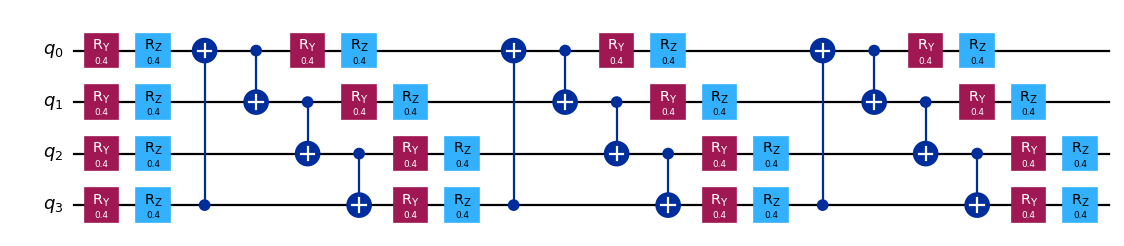

In [ ]:
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import SamplerV2
from qiskit_aer.primitives import EstimatorV2

from qiskit_addon_cutting import (
    cut_gates,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)


circuit = EfficientSU2(num_qubits=4, entanglement="circular").decompose()
circuit.assign_parameters([0.4] * len(circuit.parameters), inplace=True)


observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])
print(f"Observable: {observable}")
circuit.draw("mpl", scale=0.8)

Each of the [`CNOT`](../api/qiskit/qiskit.circuit.library.CXGate) gates between qubits $q_0$ and $q_3$ will introduce two swap gates after transpilation (assuming the qubits are connected together in a straight line). To avoid this increase in depth, we can replace these distant gates with [`TwoQubitQPDGate`s](../api/qiskit-addon-cutting/qpd-two-qubit-qpd-gate) using the [`cut_gates()`](../api/qiskit-addon-cutting/qiskit-addon-cutting#cut_gates) method.  This function will also return a list of [`QPDBasis`](../api/qiskit-addon-cutting/qpd-qpd-basis) instances - one for each decomposition.

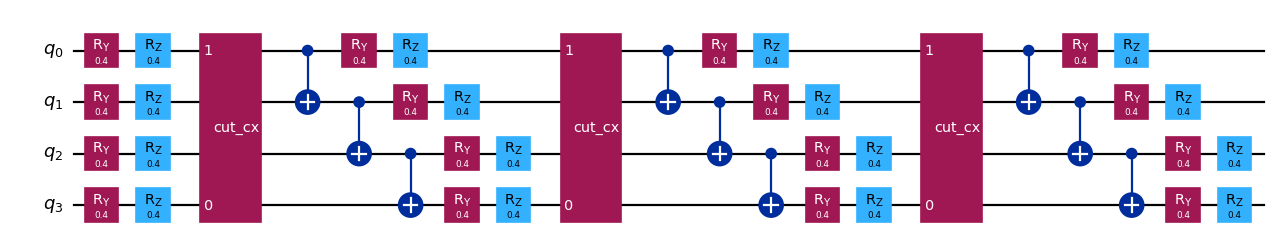

In [15]:
# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(circuit.data)
    if {circuit.find_bit(q)[0] for q in instruction.qubits} == {0, 3}
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(circuit, cut_indices)

qpd_circuit.draw("mpl", scale=0.8)

Now that the cut gate instructions have been added, the subexperiments will have a smaller depth after transpilation than the original circuit. The code snippet below generates the subexperiments using the [`generate_cutting_experiments`](../api/qiskit-addon-cutting/qiskit-addon-cutting#generate_cutting_experiments) as before, but for this example we just use the `qpd_circuit` instead of dictionaries since we did not partition the problem.

Once the subexperiments are generated, we can then transpile them and use the `Sampler` primitive to sample the distribution and reconstruct the estimated expectation values. The following code block generates the subexperiments, transpiles and executes them, then reconstructs the results and compares them to the exact expectation value.

In [16]:
# Generate the subexperiments and sampling coefficients
subexperiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=observable.paulis, num_samples=np.inf
)

# Set a backend to use and transpile the subexperiments
backend = FakeManilaV2()
pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)
isa_subexperiments = pass_manager.run(subexperiments)

# Set up the Qiskit Runtime Sampler primitive, submit the subexperiments, and retrieve the results
sampler = SamplerV2(backend)
job = sampler.run(isa_subexperiments)
results = job.result()


# Reconstruct the results
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    observable.paulis,
)
# Reconstruct final expectation value
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)

estimator = EstimatorV2()
exact_expval = estimator.run([(circuit, observable)]).result()[0].data.evs
print(
    f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}"
)
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(
    f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}"
)
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 0.54345703
Exact expectation value: 0.50497603
Error in estimation: 0.038481
Relative error in estimation: 0.07620362
